In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd
import h5py

from universality.gaussianprocess.utils import integrate_phi
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

In [2]:
file_path = '../make-agnostic-processes/hadagn/bsk/gpr_gpr_hadronic-bsk.hdf5'

In [3]:
with h5py.File(file_path, 'r') as f:
    print(f['0'].keys())

<KeysViewHDF5 ['cov', 'mean']>


In [4]:
with h5py.File(file_path, 'r') as f:
    cov = np.array(f['0']['cov'])
    mean = np.array(f['0']['mean'])

In [5]:
log_pressure = np.array([entry[0] for entry in mean])
phi = np.array([entry[1] for entry in mean])

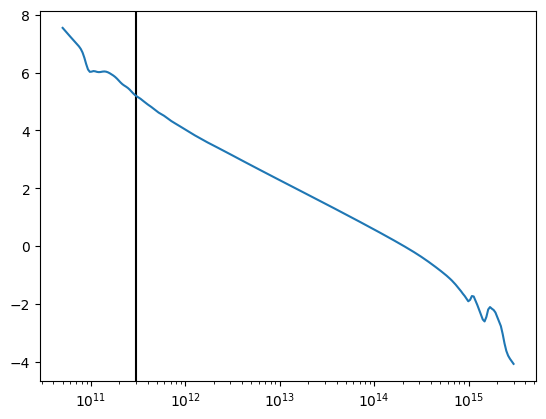

In [6]:
fig, ax = plt.subplots()
ax.set_xscale('log')

ax.plot(np.exp(log_pressure), phi)

# integrate_phi_reference_pressure
ax.axvline(3e11, c='k', zorder=0.5)

In [7]:
eos, cols = integrate_phi(
    np.exp(log_pressure),
    phi,
    reference_pressurec2=3e11,
    sigma_logpressurec2=0,
    stitch_below_reference_pressure=True,
    include_baryon_density=True,
    include_cs2c2=True,
    include_baryon_chemical_potential=False,
    verbose=True
)

performing numeric integration for energy_density via trapazoidal approximation
performing numeric integration for baryon_density via trapazoidal approximation
computing cs2c2 via numeric differentiation


In [8]:
eos, cols

(array([[3.36295248e-07, 1.31539386e+01, 1.31539389e+01, 6.35677634e-08],
        [2.14431941e-06, 4.15964079e+01, 4.15964072e+01, 7.90900128e-08],
        [1.36728240e-05, 1.31539403e+02, 1.31539389e+02, 1.59474159e-07],
        ...,
        [2.74626556e+15, 3.98608023e+15, 2.27836117e+15, 9.79858908e-01],
        [2.87033041e+15, 4.11256625e+15, 2.32078011e+15, 9.81638192e-01],
        [3.00000000e+15, 4.24455192e+15, 2.36424677e+15, 9.82452028e-01]]),
 ['pressurec2', 'energy_densityc2', 'baryon_density', 'cs2c2'])

In [9]:
pressure_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
energy_density_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
number_density_mean = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

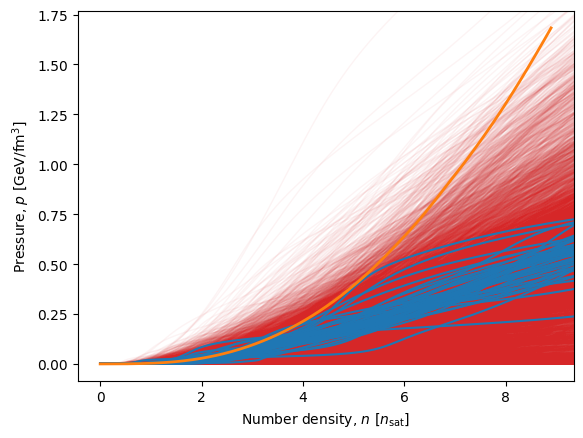

In [10]:
sets = [2, 0, 1]
N_samp = 1000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(number_density_mean/nsat, pressure_mean, c='C1', zorder=3, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [11]:
hdf5_paths = {
    'had': ['bsk', 'bsr', 'dd', 'eng', 'gm', 'kde', 'mpa', 'nl', 'r', 'sk', 'sly', 'tm'],
    'hyp': ['bsr', 'dd', 'gm', 'h', 'nl', 'tm'],
    'qrk': ['alf', 'ddq', 'hqc']
}

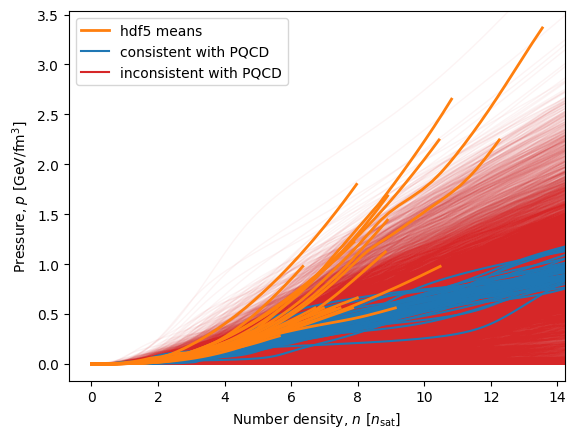

In [12]:
fig, ax = plt.subplots()

for variety in ['had', 'hyp', 'qrk']:
    for path in hdf5_paths[variety]:

        if variety == 'had':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}ronic-{path}.hdf5'
        elif variety == 'hyp':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}eronic-{path}.hdf5'
        elif variety == 'qrk':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_quark-{path}.hdf5'

        with h5py.File(file_path, 'r') as f:
            cov = np.array(f['0']['cov'])
            mean = np.array(f['0']['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        eos, cols = integrate_phi(
            np.exp(log_pressure),
            phi,
            reference_pressurec2=3e11,
            sigma_logpressurec2=0,
            stitch_below_reference_pressure=True,
            include_baryon_density=True,
            include_cs2c2=True,
            include_baryon_chemical_potential=False,
            verbose=False
        )

        pressure_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
        energy_density_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
        number_density_mean = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

        ax.plot(number_density_mean/nsat, pressure_mean, c='C1', zorder=3, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

sets = [2, 0, 1]
N_samp = 1000

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

labels = ['hdf5 means', 'consistent with PQCD', 'inconsistent with PQCD']
handles = [
    plt.Line2D([0], [0], color='C1', lw=2), 
    plt.Line2D([0], [0], color='C0'), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

/Users/eliot/Documents/Research/EOS/.venv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/eliot/Documents/Research/EOS/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


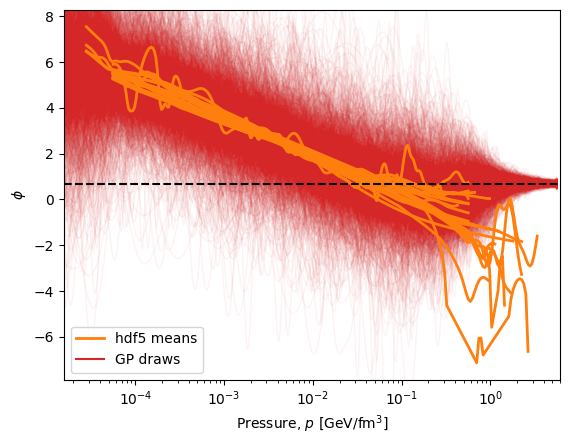

In [13]:
fig, ax = plt.subplots()
ax.set_xscale('log')

for variety in ['had', 'hyp', 'qrk']:
    for path in hdf5_paths[variety]:

        if variety == 'had':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}ronic-{path}.hdf5'
        elif variety == 'hyp':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}eronic-{path}.hdf5'
        elif variety == 'qrk':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_quark-{path}.hdf5'

        with h5py.File(file_path, 'r') as f:
            cov = np.array(f['0']['cov'])
            mean = np.array(f['0']['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        ax.plot(to_GeV_per_cubic_femtometre(np.exp(log_pressure)), phi, c='C1', zorder=3, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

sets = [0]
N_samp = 1000

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/draw-gpr_{variety}agn-{ni:06}.csv')
            
            ax.plot(
                to_GeV_per_cubic_femtometre(np.exp(eos['log(pressurec2)'])),
                eos['phi'],
                c='C3',
                alpha=0.05,
                lw=1,
                zorder=0.5
            )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

labels = ['hdf5 means', 'GP draws']
handles = [
    plt.Line2D([0], [0], color='C1', lw=2), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels)

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'$\phi$')